In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Concatenate, Reshape, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/GAN project/data.csv')
df = df.sort_values(by='Date')

numeric = list(df.select_dtypes(include='float64').drop('sentiment', axis=1).columns)

scaler = StandardScaler()
df[numeric] = scaler.fit_transform(df[numeric])

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['news'])
vocab_size = len(tokenizer.word_index) + 1

X_text = tokenizer.texts_to_sequences(df['news'])
X_text = tf.keras.preprocessing.sequence.pad_sequences(X_text)

In [ ]:
def build_generator(latent_dim, vocab_size, num_features):
    text_input = Input(shape=(None,))
    text_embedding = Embedding(vocab_size, latent_dim)(text_input)
    text_lstm = LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01))(text_embedding)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = Dropout(0.2)(text_lstm)

    ohlcv_input = Input(shape=(num_features,))
    ohlcv_input = tf.expand_dims(ohlcv_input, axis=-1)
    ohlcv_lstm = LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01))(ohlcv_input)
    ohlcv_lstm = BatchNormalization()(ohlcv_lstm)
    ohlcv_lstm = Dropout(0.2)(ohlcv_lstm)

    merged = Concatenate()([text_lstm, ohlcv_lstm])
    output = Dense(num_features, kernel_regularizer=l2(0.01))(merged)
    output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.1)(output)
    return Model(inputs=[text_input, ohlcv_input], outputs=output)

def build_discriminator(num_features):
    model = Sequential([
        Dense(64, input_shape=(num_features,), activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = generator.input
    gan_output = discriminator(generator.output)
    model = Model(gan_input, gan_output)
    return model

def gan_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients), axis=list(range(1, len(gradients.shape)))))
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    return gradient_penalty

latent_dim = 50
num_features = len(numeric)
generator = build_generator(latent_dim, vocab_size, num_features)
discriminator = build_discriminator(num_features)
gan = build_gan(generator, discriminator)

discriminator_optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
generator_optimizer = Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

discriminator.compile(optimizer=discriminator_optimizer, loss=wasserstein_loss, metrics=['accuracy'])
gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

In [ ]:
epochs = 50
batch_size = 30
half_batch = batch_size // 2

In [ ]:
# checkpoint_discriminator = ModelCheckpoint('/content/drive/MyDrive/GAN project/discriminator.h5',
#                                            save_weights_only=True,
#                                            save_best_only=False,
#                                            monitor='d_loss',
#                                            mode='min',
#                                            verbose=1)
# checkpoint_gan = ModelCheckpoint('/content/drive/MyDrive/GAN project/gan.h5',
#                                  save_weights_only=True,
#                                  save_best_only=False,
#                                  monitor='g_loss',
#                                  mode='min',
#                                  verbose=1)

real_label_smoothing = 1
discriminator_losses = []
generator_losses = []

for epoch in range(epochs):
    num_batches = len(X_text) // batch_size
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size

        real_ohlcv = df[numeric].iloc[start_idx:end_idx].values
        sequential_text = X_text[start_idx:end_idx]

        dummy_numeric_input = np.zeros((batch_size, num_features))
        generated_ohlcv = generator.predict([sequential_text, dummy_numeric_input])

        X_combined_batch = np.concatenate([real_ohlcv, generated_ohlcv])
        y_combined = np.concatenate([np.ones((batch_size, 1)) * real_label_smoothing, np.zeros((batch_size, 1))])

        d_loss = discriminator.train_on_batch(X_combined_batch, y_combined, reset_metrics=True)
        discriminator_losses.append(d_loss[0])

        dummy_numeric_input_full = np.zeros((batch_size, num_features))
        fake_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch([sequential_text, dummy_numeric_input_full], fake_labels, reset_metrics=True)
        generator_losses.append(g_loss)

    # checkpoint_discriminator.model = discriminator
    # checkpoint_discriminator.on_epoch_end(epoch)
    # checkpoint_gan.model = gan
    # checkpoint_gan.on_epoch_end(epoch)

    print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

1/1 [==============================] - 0s 59ms/step
Epoch 1/50, Discriminator Loss: 1.3720972537994385, Generator Loss: 2.6208267211914062
1/1 [==============================] - 0s 93ms/step
Epoch 2/50, Discriminator Loss: 1.3876103162765503, Generator Loss: 2.1621406078338623
1/1 [==============================] - 0s 97ms/step
Epoch 3/50, Discriminator Loss: 1.368249773979187, Generator Loss: 1.8703587055206299
1/1 [==============================] - 0s 61ms/step
Epoch 4/50, Discriminator Loss: 1.3766552209854126, Generator Loss: 1.6741633415222168
1/1 [==============================] - 0s 58ms/step
Epoch 5/50, Discriminator Loss: 1.3594218492507935, Generator Loss: 1.5758988857269287
1/1 [==============================] - 0s 59ms/step
Epoch 6/50, Discriminator Loss: 1.383232593536377, Generator Loss: 1.4533144235610962
1/1 [==============================] - 0s 59ms/step
Epoch 7/50, Discriminator Loss: 1.3491405248641968, Generator Loss: 1.4105995893478394
1/1 [========================

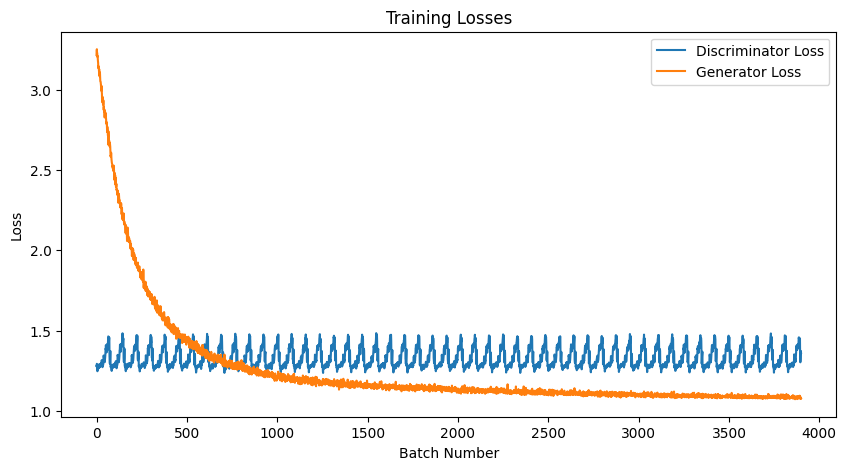

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_ohlcv(generator, text_input, last_real_ohlcv):
    text_input = tokenizer.texts_to_sequences([text_input])
    text_input = tf.keras.preprocessing.sequence.pad_sequences(text_input, maxlen=X_text.shape[1])

    generated_ohlcv = generator.predict([text_input, np.array([last_real_ohlcv])])

    return generated_ohlcv.flatten()

def generate_sequential_ohlcv(generator, text_inputs, initial_ohlcv):
    generated_ohlcv_values = []
    current_ohlcv = initial_ohlcv

    for text_input in text_inputs:
        generated_ohlcv = generate_ohlcv(generator, text_input, current_ohlcv)
        generated_ohlcv_values.append(generated_ohlcv)
        current_ohlcv = generated_ohlcv

    return generated_ohlcv_values

In [ ]:
text_inputs = [list(df.news)[-9]]

initial_ohlcv = df[numeric].iloc[-10].values
synthetic_ohlcv = generate_sequential_ohlcv(generator, text_inputs, initial_ohlcv)
print("Synthetic OHLCV:", synthetic_ohlcv)

1/1 [==============================] - 0s 68ms/step
Synthetic OHLCV: [array([ 2.6500351e+00,  1.6259568e+00,  9.7125311e+00, -6.3227132e-02,
       -4.9031740e-01,  5.6439114e-01,  1.0316281e+00,  9.5218468e+00,
        4.5590954e+00,  2.6511698e+00,  3.0850732e+00, -3.8008317e-01,
       -3.8451919e-01,  5.3201765e-01, -3.8496408e-01, -2.8323922e-01,
       -1.7295271e-01,  6.8399897e+00, -2.1258632e-02, -4.3464848e-01,
       -5.0064445e-01,  6.8687648e-01,  4.3598351e+00,  6.3718882e+00,
       -2.2937456e-01,  2.2984653e+00,  5.5702257e-01, -2.9567933e-02,
        7.3970642e+00, -5.9972383e-02,  6.6445646e+00,  1.8020835e+00,
       -7.0032671e-02,  8.3739824e+00,  8.4813671e+00,  1.7250191e+00,
        1.5837790e+00,  5.4690838e-03, -5.4189575e-01, -1.4596076e-01,
       -6.3180923e-01, -2.0020595e-01, -1.8281936e-04, -7.0783332e-02,
       -2.2229720e-02,  6.7569880e+00,  1.0274247e+00,  1.1341434e+00,
       -1.8680722e-02,  1.5366094e+00,  9.3300551e-01,  3.4880741e+00,
       

In [ ]:
synthetic = scaler.inverse_transform(synthetic_ohlcv)
actual = scaler.inverse_transform([initial_ohlcv])

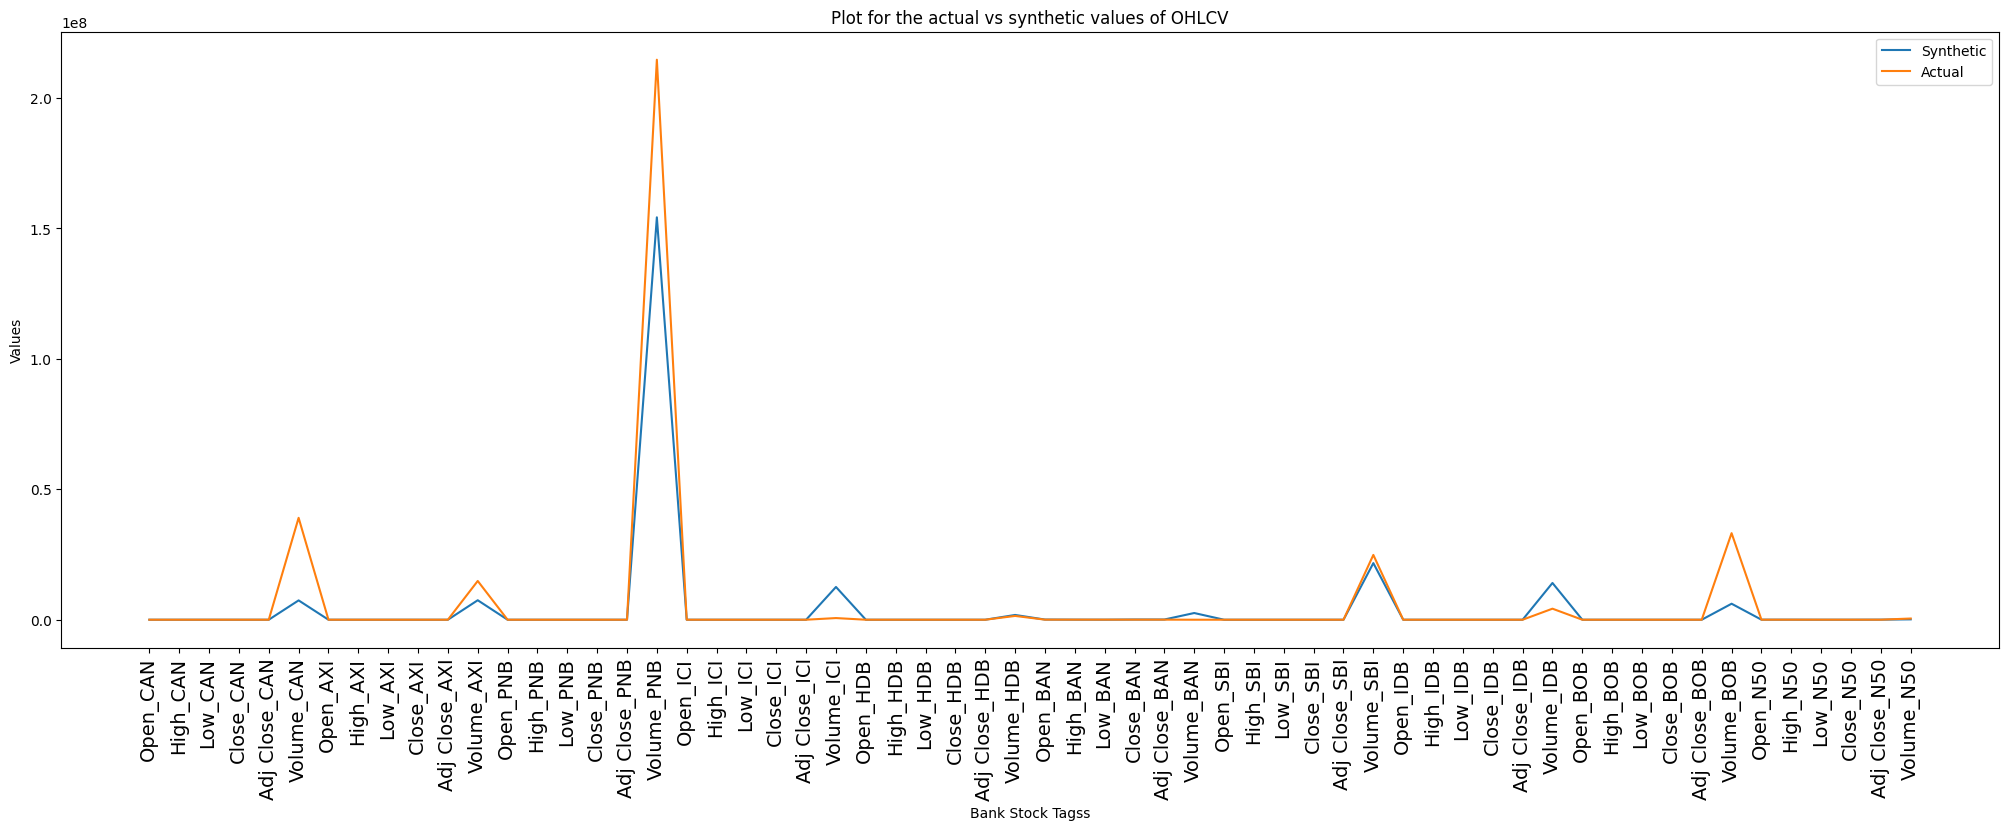

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))

plt.xlabel('Bank Stock Tags')
plt.ylabel('Values')
plt.title('Plot for the actual vs synthetic values of OHLCV')

plt.xticks(rotation='vertical', fontsize=12)  # Rotate x-axis labels to vertical and increase font size
plt.tick_params(axis='x', labelsize=14)

plt.plot(numeric, synthetic[0], label='Synthetic')
plt.plot(numeric, actual[0], label='Actual')
plt.legend()

# Show the plot
plt.show()


In [ ]:
n = []
s = []
a = []

for (x, y, z) in zip(numeric, synthetic[0], actual[0]):
  if "Volume" in x:
    continue
  else:
    n.append(x)
    s.append(y)
    a.append(z)

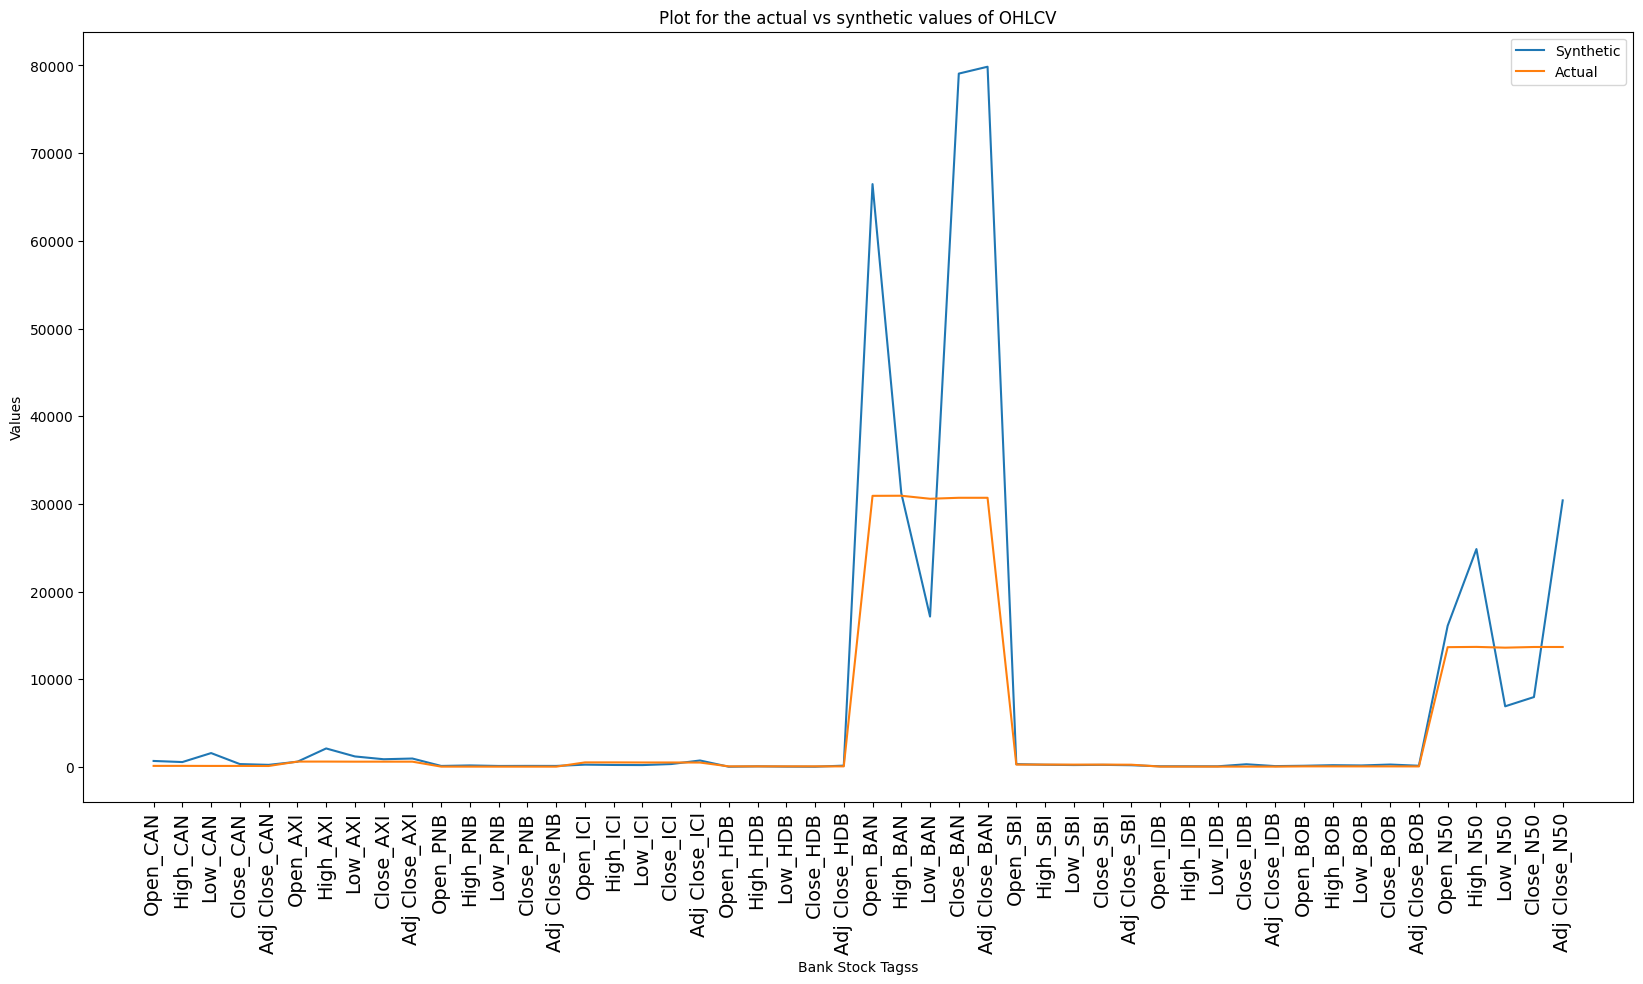

In [ ]:

plt.figure(figsize=(20,10))

plt.xlabel('Bank Stock Tags')
plt.ylabel('Values')
plt.title('Plot for the actual vs synthetic values of OHLCV')

plt.xticks(rotation='vertical', fontsize=12)  # Rotate x-axis labels to vertical and increase font size
plt.tick_params(axis='x', labelsize=14)

plt.plot(n, s, label='Synthetic')
plt.plot(n, a, label='Actual')
plt.legend()

# Show the plot
plt.show()